In [21]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

In [8]:
import pandas as pd
import os 

BASE_DIR = os.getcwd() # Get current working directory
file_path = os.path.join(BASE_DIR, "icd10_grouping", 'daily_category_patients_top6.csv')
df = pd.read_csv(file_path, parse_dates=['Day'])
df = df.sort_values('Day')
print(df.head())

         Day  Symptoms & Abnormal Findings  Heart / Circulatory  \
0 2019-01-01                             4                    5   
1 2019-01-02                            11                    6   
2 2019-01-03                             6                    7   
3 2019-01-04                            15                   10   
4 2019-01-05                            13                    4   

   Injury / Physical harm  Digestive  Respiratory  Mental Health  \
0                       3          1            2              3   
1                       1          2            4              3   
2                       6          4            1              1   
3                       1          6            5              2   
4                       6          1            2              1   

   Total Patients  
0              18  
1              27  
2              25  
3              39  
4              27  


In [9]:
lag_days = 1  # use previous day's counts as features
category_cols = df.columns[1:-1]  # all diagnosis columns (exclude Day & Total Patients)

for col in category_cols:
    df[f'{col}_lag1'] = df[col].shift(lag_days)

# Add temporal features
df['day_of_week'] = df['Day'].dt.dayofweek
df['month'] = df['Day'].dt.month

# Drop first row (NaN due to lag)
df_features = df.dropna().reset_index(drop=True)

In [10]:
feature_cols = [c for c in df_features.columns if '_lag' in c] + ['day_of_week', 'month']
X = df_features[feature_cols]
y = df_features[category_cols]  # predict counts for each category

In [16]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [28]:
xgb = MultiOutputRegressor(XGBRegressor(
    n_estimators=150,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
))

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)


In [29]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")


Mean Squared Error: 4.942802429199219
Root Mean Squared Error: 2.223241423957196
Mean Absolute Error: 1.66675865650177
R^2 Score: -0.027202090248465538


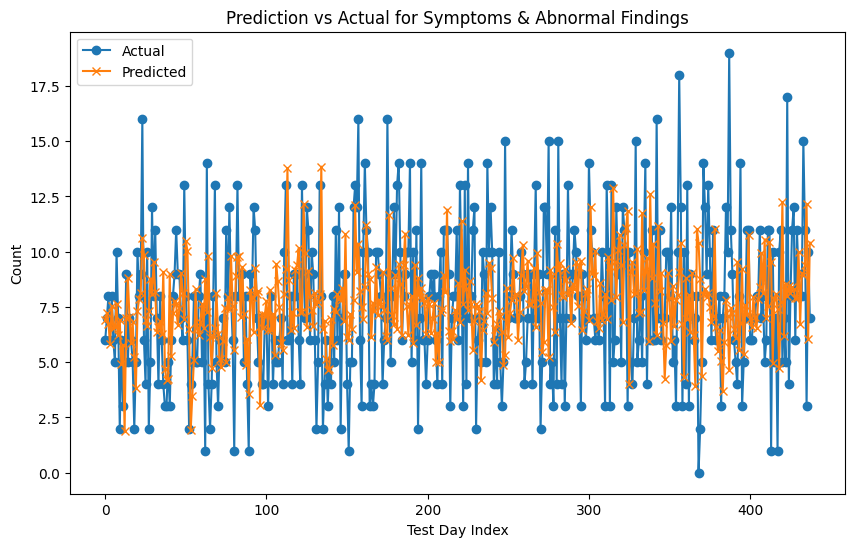

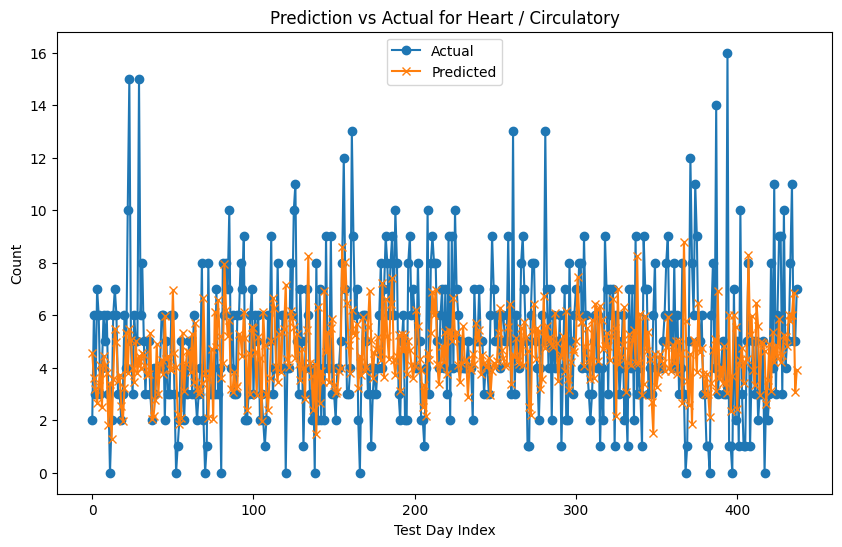

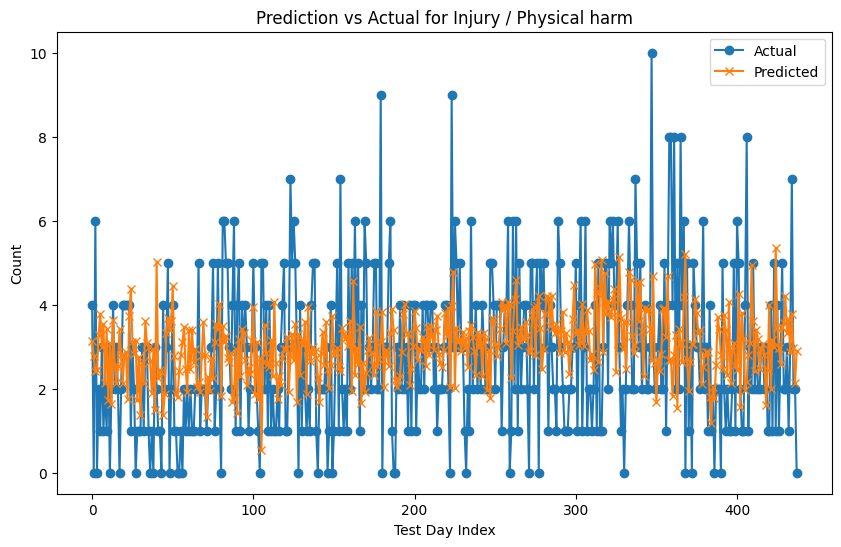

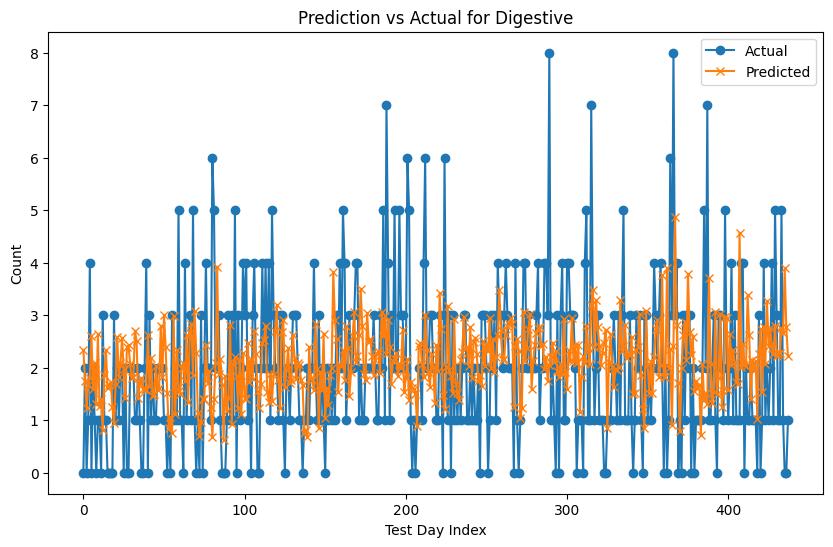

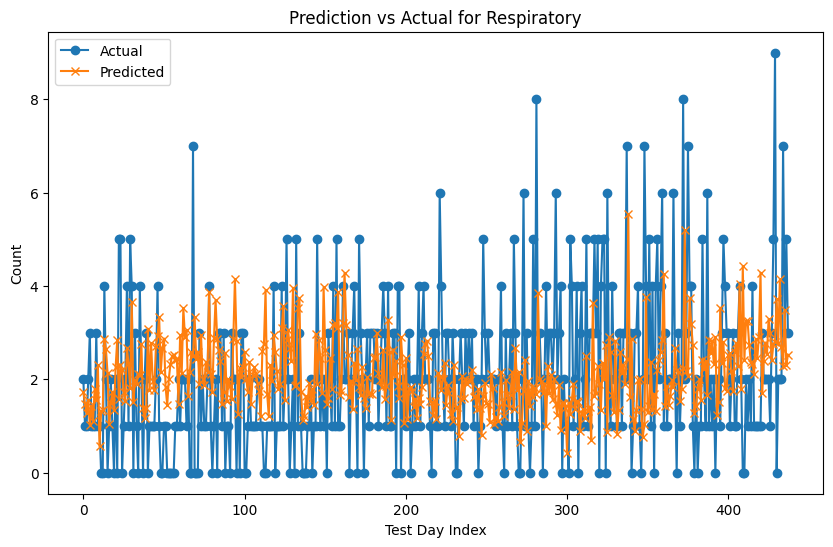

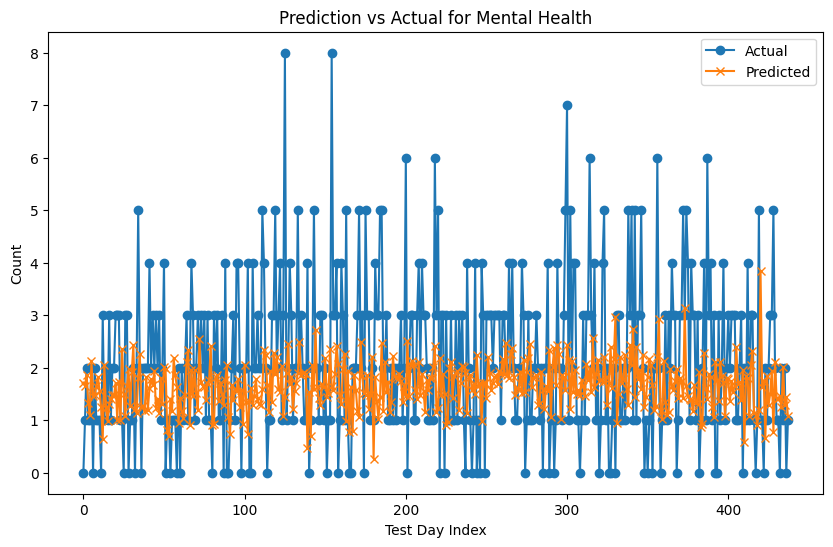

In [23]:
for i, col in enumerate(category_cols):
    plt.figure(figsize=(10,6))
    plt.plot(y_test[col].values, label='Actual', marker='o')
    plt.plot(y_pred[:, i], label='Predicted', marker='x')
    plt.title(f"Prediction vs Actual for {col}")
    plt.xlabel("Test Day Index")
    plt.ylabel("Count")
    plt.legend()
    plt.show()